## Intro

Initial EDA was conducted as part of the first version of recommender system (see content-recsys-notebook)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Database connection URI
from kaggle_secrets import UserSecretsClient

secret_label = 'conn_uri'
conn_uri = UserSecretsClient().get_secret(secret_label)

In [4]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.7 MB/s eta 0:00:00


In [5]:
data = pd.read_sql(
    '''
    SELECT
        public.feed_data.timestamp,
        public.feed_data.user_id,
        public.feed_data.post_id,
        public.feed_data.target,
        public.user_data.gender,
        public.user_data.age,
        public.user_data.country,
        public.user_data.city,
        public.user_data.exp_group,
        public.user_data.os,
        public.user_data.source
    FROM public.feed_data
    TABLESAMPLE BERNOULLI (0.5)
    INNER JOIN public.post_text_df
    ON public.feed_data.post_id=public.post_text_df.post_id
    INNER JOIN public.user_data
    ON public.feed_data.user_id=public.user_data.user_id
    ''',
    conn_uri
)

In [6]:
# Extracting datetime features: date, month, day of week, hour

data['date'] = data.timestamp.dt.date
data['month'] = data.timestamp.dt.month
data['day_of_week'] = data.timestamp.dt.dayofweek
data['hour'] = data.timestamp.dt.hour

## Feature Engineering

#### Text clustering using Transformers
The idea is to get text embeddings of posts using state-of-the-art NLP models (BERT, RoBERTa, DeBERTa, etc.)

Then we can use a clustering algorithm, i.e. k-means, to create clusters of similar posts.

Additional information about clustering should presumably benefit the Catboost model performance.

In [7]:
df_posts = pd.read_sql(
    '''
    SELECT *
    FROM public.post_text_df
    ''',
    conn_uri
)
df_posts

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [8]:
from transformers import AutoTokenizer
from transformers import AutoModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'deberta']

    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'deberta': 'microsoft/deberta-v3-base'  # https://huggingface.co/microsoft/deberta-v3-base
    }

    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), AutoModel.from_pretrained(checkpoint_names[model_name])

In [9]:
tokenizer, model = get_model('roberta')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(df_posts['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

In [11]:
import torch
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)

cuda:0
Tesla P100-PCIE-16GB


In [13]:
embeddings = get_embeddings_labels(model, loader).numpy()
embeddings

100%|██████████| 220/220 [01:53<00:00,  1.94it/s]


array([[-0.0386057 ,  0.09835505,  0.02948263, ..., -0.08099239,
        -0.03544499, -0.04847637],
       [-0.00790161,  0.08904035,  0.04218233, ..., -0.07876968,
        -0.02434699,  0.01079475],
       [-0.06683062,  0.11239152,  0.03230258, ..., -0.12619457,
        -0.08494119, -0.01880301],
       ...,
       [-0.07701661,  0.05103108, -0.02830478, ..., -0.13749714,
        -0.05310532, -0.03514053],
       [-0.07431208,  0.08764903,  0.01007027, ..., -0.12020964,
        -0.00962677, -0.04021227],
       [-0.10920744,  0.09746821, -0.00142146, ..., -0.07132419,
         0.00438616,  0.04553585]], dtype=float32)

In [14]:
embeddings.shape

(7023, 768)

In [15]:
from sklearn.decomposition import PCA

centered = embeddings - embeddings.mean()
pca = PCA(n_components=30)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)
df_posts_clustering = df_posts.copy()
df_posts_clustering['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']
df_dists = pd.DataFrame(data=kmeans.transform(pca_decomp), columns=dists_columns)

df_posts_clustering = pd.concat((df_posts_clustering, df_dists), axis=1)
df_posts_clustering = df_posts_clustering.drop(['text'], axis=1)
df_posts_clustering.head()

,post_id,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,business,6,1.050889,1.207836,0.798138,0.485486,0.612790,1.336404,0.454504,1.249585,0.791558,1.131962,1.299609,1.073963,0.770392,0.929518,0.692307
1,2,business,3,0.901539,1.085174,0.644537,0.287500,0.468443,1.213891,0.397038,1.098615,0.584630,0.993576,1.175868,0.870792,0.600673,0.756438,0.536264
2,3,business,6,0.885362,1.204498,0.661438,0.561706,0.658659,1.190937,0.368483,1.237542,0.651768,0.956100,1.105168,1.037589,0.675989,0.768604,0.583091
3,4,business,6,0.932174,1.054059,0.741978,0.441795,0.721656,1.179358,0.393844,1.066680,0.699694,0.980931,1.167418,0.866976,0.743663,0.797625,0.661652
4,5,business,6,0.746481,1.001756,0.619650,0.487365,0.630494,1.008888,0.374591,1.036437,0.478295,0.830793,0.967534,0.853987,0.605490,0.685166,0.566810


In [16]:
data = pd.merge(data,
              df_posts_clustering,
              on='post_id',
              how='left')

data.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-10-25 06:56:09,3726,1758,0,0,22,Russia,Novosibirsk,1,Android,...,1.130182,0.903587,0.921397,0.809283,1.056798,1.175230,0.882895,0.674654,0.951545,0.997468
1,2021-10-24 06:48:25,54095,6641,0,0,34,Ukraine,Mariupol,3,iOS,...,0.951682,1.092980,1.262926,0.887997,0.419723,0.550954,1.017470,1.035879,0.652880,1.048928
2,2021-11-07 13:30:24,54095,1267,1,0,34,Ukraine,Mariupol,3,iOS,...,1.120819,0.450507,1.222398,0.546754,0.879052,1.010304,0.982070,0.565227,0.725249,0.458224
3,2021-12-02 07:21:12,3726,5716,0,0,22,Russia,Novosibirsk,1,Android,...,0.893501,0.865182,1.196891,0.709855,0.372075,0.502963,0.865474,0.840037,0.504786,0.785299
4,2021-12-13 22:30:30,3726,3694,1,0,22,Russia,Novosibirsk,1,Android,...,0.865439,1.147148,0.297124,1.075002,1.188596,1.302409,0.849209,1.120653,1.144911,1.225778


#### Likes per user

In [17]:
# SQL request from database to make data available for all users.
# Timestamp condition is due to prevent data leakage. See below.

df_utl = pd.read_sql(
    '''
    SELECT user_id, COUNT(post_id) AS user_total_likes
    FROM public.feed_data
    WHERE timestamp < '2021-12-15 00:00:00' AND target = 1
    GROUP BY user_id
    ''',
    conn_uri
)
df_utl

,user_id,user_total_likes
0,200,37
1,201,46
2,202,69
3,203,43
4,204,13
...,...,...
163177,168548,18
163178,168549,21
163179,168550,37
163180,168551,43


In [18]:
data = pd.merge(data,
              df_utl,
              on='user_id',
              how='left')
data['user_total_likes'] = data['user_total_likes'].fillna(0).astype(int)

## CatBoost Training

In [19]:
data.columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'gender', 'age', 'country',
       'city', 'exp_group', 'os', 'source', 'date', 'month', 'day_of_week',
       'hour', 'topic', 'TextCluster', 'DistanceTo1thCluster',
       'DistanceTo2thCluster', 'DistanceTo3thCluster', 'DistanceTo4thCluster',
       'DistanceTo5thCluster', 'DistanceTo6thCluster', 'DistanceTo7thCluster',
       'DistanceTo8thCluster', 'DistanceTo9thCluster', 'DistanceTo10thCluster',
       'DistanceTo11thCluster', 'DistanceTo12thCluster',
       'DistanceTo13thCluster', 'DistanceTo14thCluster',
       'DistanceTo15thCluster', 'user_total_likes'],
      dtype='object')

In [20]:
# Dropping redundant columns

data = data.drop(['user_id', 'post_id', 'date'], axis=1)

In [21]:
# Since we have a time-series data, we can split train and test on a certain date.
# That way we test a model generalization ability for future prediction.

min(data.timestamp), max(data.timestamp)

(Timestamp('2021-10-01 06:01:40'), Timestamp('2021-12-29 23:39:10'))

In [22]:
# Let's split on 2021-12-15
# It should provide roughly an 80% to 20% ratio

data_train = data[data.timestamp < '2021-12-15']
data_test = data[data.timestamp >= '2021-12-15']

data_train = data_train.drop('timestamp', axis=1)
data_test = data_test.drop('timestamp', axis=1)

In [23]:
X_train = data_train.drop('target', axis=1)
X_test = data_test.drop('target', axis=1)

y_train = data_train['target']
y_test = data_test['target']

In [24]:
y_train.shape, y_test.shape

((319383,), (64965,))

In [25]:
from catboost import CatBoostClassifier

cat_cols = ['TextCluster', 'topic', 'gender', 'country', 'city', 'exp_group', 'os', 'source', 'month', 'day_of_week', 'hour']

model = CatBoostClassifier(
    loss_function='Logloss',
    cat_features=cat_cols,
    verbose=100
)

model.fit(X_train, y_train)

Learning rate set to 0.120858
0:	learn: 0.5980283	total: 930ms	remaining: 15m 28s
100:	learn: 0.3198474	total: 1m 4s	remaining: 9m 31s
200:	learn: 0.3170493	total: 2m 14s	remaining: 8m 54s
300:	learn: 0.3150223	total: 3m 23s	remaining: 7m 52s
400:	learn: 0.3131864	total: 4m 32s	remaining: 6m 47s
500:	learn: 0.3115503	total: 5m 42s	remaining: 5m 41s
600:	learn: 0.3100167	total: 6m 54s	remaining: 4m 34s
700:	learn: 0.3084355	total: 8m 4s	remaining: 3m 26s
800:	learn: 0.3068124	total: 9m 14s	remaining: 2m 17s
900:	learn: 0.3051436	total: 10m 24s	remaining: 1m 8s
999:	learn: 0.3037159	total: 11m 35s	remaining: 0us


In [26]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.880     1.000     0.936     57166
           1      0.000     0.000     0.000      7799

    accuracy                          0.880     64965
   macro avg      0.440     0.500     0.468     64965
weighted avg      0.774     0.880     0.824     64965



roc_auc = 0.629


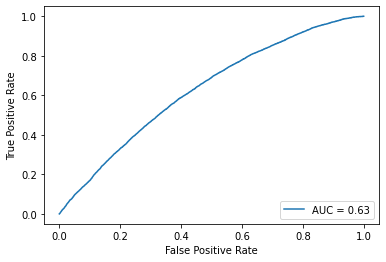

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f'roc_auc = {roc_auc.round(3)}')
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

Text(0.5, 1.0, 'Feature Importance')

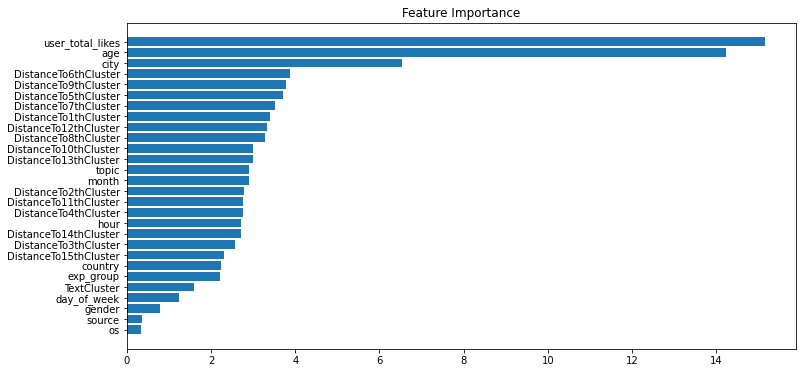

In [28]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [29]:
# Saving model to use it in a service

model.save_model('catboost_model_02_roberta', format='cbm')

In [30]:
# Saving text clustering features to the database

df_posts_clustering.to_sql(
   "ignatev_df_posts_clustering_roberta",
    con=conn_uri,
    schema="public",
    if_exists='replace'
   )

## Performance Metrics

Performance assessment was implemented in web-based checker using **hitrate@5** metric:

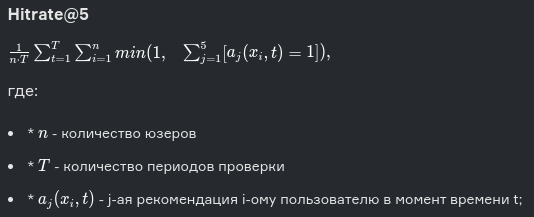

Checker results:

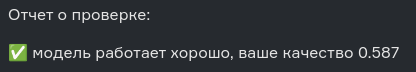